In [1]:
%pylab notebook
import cv2

Populating the interactive namespace from numpy and matplotlib


In [2]:
def paddingImage(img, size):
    """
    function to add padding to the image so as to process the boundaries pixel of the image
    img: image to be padded
    size: kernel size
    return: padded image
    """
    
    k = int((size-1)/2)
    
    paddedImage = pad(img, ((k,),(k,)), 'constant')   
   
    return(paddedImage)

In [3]:
def normalizeMatrix (img, i , j, k):
    """
    function to calculate the mean of the region, subtract mean from each pixel in the region and return the zero mean template
    img: image region which is to be processed
    i, j: the location of the current pixel
    k: size of the kernel
    return: zero mean sub region
    """
    
    row = list(range(i-k, i+k+1))
    col = list(range(j-k, j+k+1))
    
    # calculating mean at every sub matrix extracted and subtracting it from the sub matrix
    subMatrix = img[np.ix_(row, col)]
    m = np.mean(subMatrix)
    normSubMatrix = subMatrix - m
    
    return(normSubMatrix)
   

In [9]:
def calculateDisparity (img1 ,img2, size):
    """
    function to calculate the disparity between the two images
    img1: left image
    img2: right image
    size: kernel size
    return: disparity as a 2d array
    """
    #height and width of the left image
    h,w = img1.shape 
    
    disp=0

    #initialise the disparity matrix with zeros
    disparity = zeros((h,w))
        
    k = int( (size-1)/2 )
    
    # for traversing through the height of left image
    for i in range(k, h-k):
        # for traversing through the width of left image
        for j in range(k, w-k):
            maxNCC = -2
            
            #calling the routine to extract sub matrix and produce zero mean template  
            temp1 = normalizeMatrix(img1, i , j, k )
            
            #for traversing through corresponding scan line of right image
            for u in range(j-100, j):
                if u<0:
                    temp=k
                else:
                    temp=u
                #calling the routine to extract sub matrix and produce zero mean template for right image
                temp2 = normalizeMatrix(img2, i , temp, k)
                #performing cross correlation
                num = np.multiply(temp1,temp2)
                num = sum(num)
                den = (np.linalg.norm(temp1)) * (np.linalg.norm(temp2))
                ncc = float(num/den)
                
                # comparing the maximas and storing the maximum value
                if(ncc > maxNCC):
                    maxNCC = ncc
                    #calculate the disparity as the difference of the pixel location in both the images
                    disp = temp - j
            
            disparity[i][j] = disp

            
        
    return disparity
            
            

In [12]:
# Reading the Left and Right Image
imgLeft = cv2.imread("im0.png" , 0)
imgRight = cv2.imread("im1.png" , 0)

#reszing the image
imgL = cv2.resize(imgLeft, (494, 330))   
imgR = cv2.resize(imgRight, (494, 330))

# Define a size of window
size = 11

# for padding image
img1 = paddingImage(imgL, size)
img2 = paddingImage(imgR, size)

# print(img1.shape)

disparity = calculateDisparity (img1 ,img2, size)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


In [22]:
#calculate the depth from the disparity
import copy

focal_length = 3979.911
baseline = 193.001
doffs = 124.343
disparity = np.abs(disparity)
disparity += 1

value  = focal_length * baseline
disparity = disparity + doffs

depth = np.divide(value, disparity)

#normalize the depth map 

depthMax = np.max(depth)
depthMin = np.min(depth)
num = 255
den = depthMax-depthMin

normalize_depth = copy.deepcopy(depth)
normalize_depth -= depthMin
normalize_depth *= 255
normalize_depth /= (depthMax - depthMin)

<IPython.core.display.Javascript object>


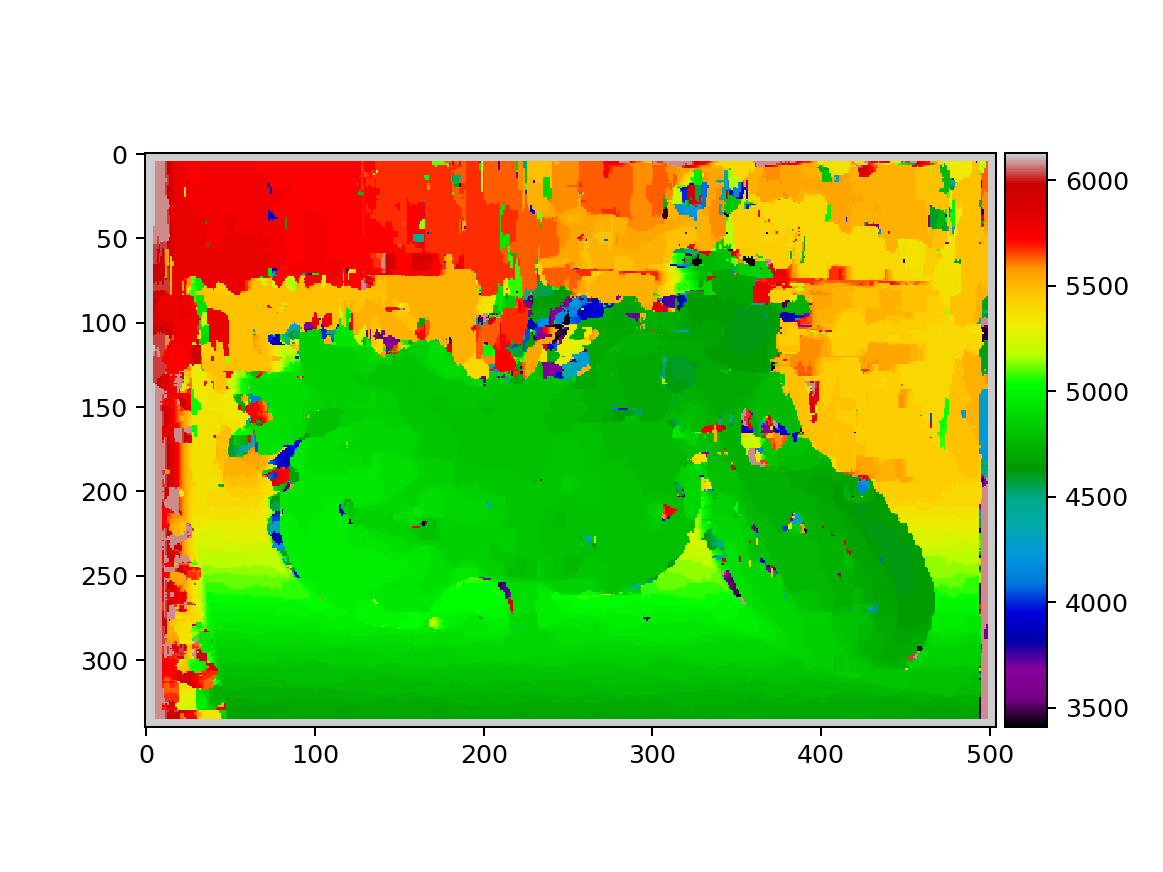

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning:

The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.



In [23]:
#cell to plot the depth map
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig1, ax1 = plt.subplots()
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)

im1 = ax1.imshow(depth, cmap='spectral')

fig1.colorbar(im1, cax=cax, orientation='vertical')
plt.show()

In [24]:
z = depth.flatten()

In [27]:
import plotly
plotly.tools.set_credentials_file(username='##########', api_key='###########')
inpImg = depth
diff = np.amax(depth) - np.amin(depth)
new = np.ones(depth.shape)
new = new * diff
plotImg = np.subtract(depth, new)
plotImg = (plotImg / diff) * 255
finalPlot = np.ones(depth.shape, dtype=np.uint8)
finalPlot = plotImg

In [28]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Surface(z=finalPlot)
]

layout = go.Layout(
    title='Interactive Depth Map',
    width=700,
    height=700,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

